In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [2]:
file_path = 'C:/Users/Tim/Desktop/lighthouse/w6 - midterm/'
# filename = file_path+'flights.csv'

# n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
# s = 50000 #desired sample size
# skip = sorted(random.sample(range(1,n+1),n-s))
# df = pd.read_csv(filename,skiprows=skip)

filename = file_path+'mini_sample.csv'
df = pd.read_csv(filename)

In [3]:
df = df.replace([np.inf, -np.inf], np.nan)

In [4]:
def info(x):
    n_missing = x.isnull().sum().sort_values(ascending=False)
    p_missing = (x.isnull().sum()/x.isnull().count()).sort_values(ascending=False)
    dtype = x.dtypes
    count = x.count()
    missing_ = pd.concat([n_missing, p_missing, dtype, count],axis=1, keys = [
        'number_missing',
        'percent_missing',
        'type',
        'count'
    ])
    return missing_

In [5]:
info(df)

,number_missing,percent_missing,type,count
weather_type,0,0.0,object,50000
cancelled,0,0.0,int64,50000
wheels_off,0,0.0,float64,50000
wheels_on,0,0.0,float64,50000
taxi_in,0,0.0,float64,50000
...,...,...,...,...
crs_dep_hour,0,0.0,int64,50000
crs_arr_hour,0,0.0,int64,50000
day_of_year,0,0.0,int64,50000
weekday,0,0.0,int64,50000


In [6]:
[i for i in df.columns]

['fl_date',
 'mkt_unique_carrier',
 'branded_code_share',
 'mkt_carrier',
 'mkt_carrier_fl_num',
 'op_unique_carrier',
 'tail_num',
 'op_carrier_fl_num',
 'origin_airport_id',
 'origin',
 'origin_city_name',
 'dest_airport_id',
 'dest',
 'dest_city_name',
 'crs_dep_time',
 'dep_time',
 'dep_delay',
 'taxi_out',
 'wheels_off',
 'wheels_on',
 'taxi_in',
 'crs_arr_time',
 'arr_time',
 'arr_delay',
 'cancelled',
 'diverted',
 'crs_elapsed_time',
 'actual_elapsed_time',
 'air_time',
 'flights',
 'distance',
 'origin_fl_density',
 'dest_fl_density',
 'day',
 'month',
 'year',
 'weekday',
 'day_of_year',
 'crs_arr_hour',
 'crs_dep_hour',
 'timestamp',
 'crs_arr_daytime',
 'crs_dep_daytime',
 'predicted_speed',
 'actual_speed',
 'origin_num_passengers',
 'dest_num_passengers',
 'origin_num_freight',
 'dest_num_freight',
 'origin_num_intl_dep',
 'dest_num_intl_dep',
 'origin_num_intl_arr',
 'dest_num_intl_arr',
 'dist_group',
 'season',
 'dep_early_morning',
 'origin_airport_size',
 'dest_airpo

In [7]:
data = copy.deepcopy(df)

In [8]:
# cols with > 80% missing values

drop = [
    'no_name',
    'total_add_gtime',
    'first_dep_time',
    'longest_add_gtime',
    'cancellation_code',
]

# missing 80%+ values, but apparently useful?

delay_cols = [
    'late_aircraft_delay',
    'security_delay',
    'nas_delay',
    'weather_delay',
    'carrier_delay'
]

In [9]:
# split city and country

data[['origin_city', 'origin_country']] = data['origin_city_name'].str.split(',', expand=True, n=2)

data[['dest_city', 'dest_country']] = data['dest_city_name'].str.split(',', expand=True, n=2)

# try using just city data, groupby country data?

In [10]:
# removing related carrier identifiers; commented out = used feature

carrier_identifiers = [
    'mkt_unique_carrier',
    'branded_code_share',
    'mkt_carrier',
    'mkt_carrier_fl_num',
    #'op_unique_carrier',
    'tail_num',
    'op_carrier_fl_num',
]

# removing related airport, place identifiers

place_identifiers = [
#origin identifiers
    'origin_airport_id',
    #'origin',
    'origin_city_name',
    #'origin_city',
    #'origin_country',
#destination identifiers
    'dest_airport_id',
    #'dest',
    'dest_city_name',
    #'dest_city',
    #'dest_country',
]

In [11]:
# remove cols

data = data.drop(columns=
                #drop+
                #delay_cols+ # not really sure what to do with these columns
                carrier_identifiers+
                place_identifiers)

In [12]:
X = data.drop(columns = 'arr_delay')

In [13]:
# avg flights per hr per airport -> fl traffic

data['hrly_bin'] = round(data['arr_time'],-2)
data['avg_hr_fl'] = data.groupby('dest')['hrly_bin'].transform(lambda x: len(x)/x.nunique())

In [14]:
# datetime

import datetime as dt
from datetime import date, time

In [15]:
# data['fl_date'] = pd.to_datetime(data['fl_date'])

# # month and year

# data['day_of_week'] = data['fl_date'].dt.date.isowekday()
# data['month'] = data['fl_date'].dt.month
# data['year'] = data['fl_date'].dt.year
data = data.sort_values(by=['fl_date'])

# dep_delay 7 day lag

data['dep_delay_lag'] = data['dep_delay'].shift(7)
data['arr_delay_lag'] = data['arr_delay'].shift(7)

# dep_delay 7 day mean

data['ddl_rolling_mean'] = data['dep_delay'].rolling(window=7).mean()

data = data.drop(columns = 'fl_date')

In [16]:
data['adl_rolling_mean'] = data['arr_delay'].rolling(window=7).mean()
data['adl_rolling_mean_origin'] = data.groupby('origin')['adl_rolling_mean'].transform(lambda x: len(x)/x.nunique())
data = data.fillna(0)

In [17]:
# correlation in X

# corr_matrix = X.corr()
# for i in corr_matrix:
#     for j in corr_matrix:
#         if i != j:
#             if abs(corr_matrix[i][j]) > 0.85:
#                 print(f"{i}\t{j}\t{abs(corr_matrix[i][j])}")

In [18]:
# dep_time	          wheels_off	0.9725230213908642
# wheels_on	          arr_time	    0.9630471247128861
# crs_elapsed_time	  distance	    0.9827710593474663
# actual_elapsed_time air_time	    0.985116094313287

# flights = column of 1s

corr_drop = [
    'flights',
    'wheels_off',  #dep/arr time could have information on whether or not time of day affects delay
    'wheels_on',   #wheels off/on probably time spent in tarmac
    'timestamp',
    'dist_group',
    'crs_dep_time',
    'crs_arr_time'
]

# don't use dep_delay

extra_drop = [
    'actual_elapsed_time',
    'dep_delay',
    'arr_time',
    'dep_time'
]


data = data.drop(columns=corr_drop+extra_drop)

In [19]:
checkpoint = copy.deepcopy(data)

In [20]:
data.dtypes

op_unique_carrier                 object
origin                            object
dest                              object
taxi_out                         float64
taxi_in                          float64
arr_delay                          int64
cancelled                          int64
diverted                           int64
crs_elapsed_time                   int64
air_time                         float64
distance                           int64
origin_fl_density                  int64
dest_fl_density                    int64
day                                int64
month                              int64
year                               int64
weekday                            int64
day_of_year                        int64
crs_arr_hour                       int64
crs_dep_hour                       int64
crs_arr_daytime                    int64
crs_dep_daytime                    int64
predicted_speed                  float64
actual_speed                     float64
origin_num_passe

In [20]:
# dummy variables - keep in mind the column used from identifiers
# commented out variables = removed

categorical_variables = [
# aircraft
    #'mkt_unique_carrier',
    #'branded_code_share',
    #'mkt_carrier',
    #'mkt_carrier_fl_num',
    'op_unique_carrier',
    #'tail_num',
    #'op_carrier_fl_num',
    
# place
    'origin',
    #'origin_city_name',
    'origin_city', # engineered
    'origin_country', # engineered
    'dest',
    #'dest_city_name',
    'dest_city', # engineered
    'dest_country', # engineered
    
#id
    #'origin_airport_id',
    #'dest_airport_id',
    
    #'dup' #duplicate flag marked y if flight is swapped based on form-3a data
    
    
    'weather_type'
]

data = pd.get_dummies(data=data,columns=categorical_variables,drop_first=True)

In [22]:
# reshuffle
data = data.sample(frac=1)
data = data.reset_index()
data = data[data['arr_delay']<=200]

In [21]:
checkpoint_2 = copy.deepcopy(data)

In [22]:
# X = data.drop(columns='arr_delay')
# y = data['arr_delay']

X = data.drop(columns = ['arr_delay','adl_rolling_mean'])
y = data['adl_rolling_mean_origin']

In [23]:
np.any(np.isnan(X))

False

In [24]:
np.all(np.isfinite(X))

True

In [25]:
y.describe()

count    50000.000000
mean         2.700671
std          1.145343
min          1.000000
25%          1.737201
50%          2.694878
75%          3.593750
max          5.107081
Name: adl_rolling_mean_origin, dtype: float64

<AxesSubplot:xlabel='adl_rolling_mean_origin', ylabel='Count'>

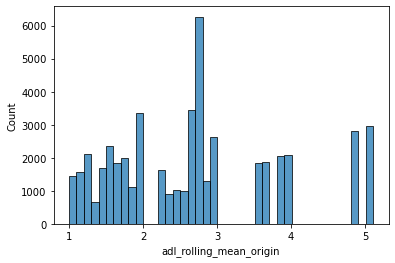

In [26]:
sns.histplot(y)

<AxesSubplot:xlabel='month', ylabel='adl_rolling_mean_carrier'>

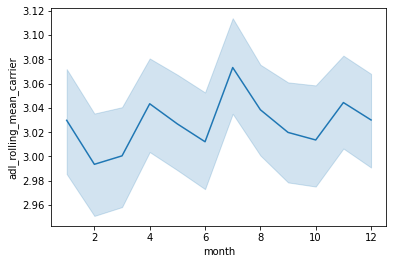

In [26]:
sns.lineplot(y=data['adl_rolling_mean_carrier'],x='month',data=data)

In [27]:
# scale/normalize

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

#scaling

scaler = StandardScaler()
scaler.fit(X)

X_scale = scaler.transform(X)

<AxesSubplot:xlabel='adl_rolling_mean_origin', ylabel='Count'>

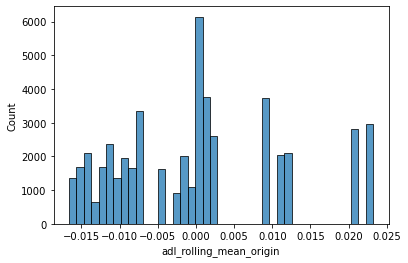

In [28]:
# normalize y

from scipy.stats import boxcox
from numpy import log

y_ = y + 100
y_ = log(y_)
y_ = y_ - y_.mean()
sns.histplot(y_)

In [32]:
# binning y

bin_y = round(y/60)
bin_y.unique()

array([ 0.,  1.,  2.,  3., -1.])

In [29]:
# running models on scaled data - non-pca'd
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(X_scale,y_,train_size=0.7,random_state=123)
Ox_train,Ox_test,Oy_train,Oy_test = train_test_split(X,y,train_size=0.7,random_state=123)

Ox_train,Ox_test,y_train,y_test = train_test_split(X,y_,train_size=0.7,random_state=123)
x_train,x_test,Oy_train,Oy_test = train_test_split(X_scale,y,train_size=0.7,random_state=123)

In [30]:
from sklearn.linear_model import Lasso, Ridge, SGDRegressor, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import cross_val_score

In [44]:
regs = {
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
    'DecisionTree': DecisionTreeRegressor(),
    #'SVR': SVR(),
    #'KNN': KNeighborsRegressor()
}

for key, reg in regs.items():
    reg.fit(x_train,Oy_train)
    train_score = cross_val_score(reg,x_train,Oy_train,cv=10)
    print(f'Regressor:\tScore:\n{key}\t{round(train_score.mean(),2)*100}')

Regressor:	Score:
Lasso	-0.0
Regressor:	Score:
Ridge	-1.0
Regressor:	Score:
ElasticNet	-0.0
Regressor:	Score:
DecisionTree	-81.0


In [ ]:
"""
with 30 day moving average
x, 0y = x_scaled, y

Regressor:	Score:
Lasso	5.0
Regressor:	Score:
Ridge	5.0
Regressor:	Score:
ElasticNet	6.0
Regressor:	Score:
DecisionTree	-10.0

x, y = x_scaled, log(y)

Regressor:	Score:
Lasso	-0.0
Regressor:	Score:
Ridge	-1.0
Regressor:	Score:
ElasticNet	-0.0
"""

In [31]:
# using ensemble methods

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBRegressor

In [32]:
# xgb

data_dmatrix = xgb.DMatrix(data=X,label=y)

model = XGBRegressor(objective ='reg:squarederror',learning_rate = 0.03)
model.fit(x_train,Oy_train)

train_score = cross_val_score(model,x_train,Oy_train,cv=10)
print(round(train_score.mean(),2)*100)

99.0


In [ ]:
"""
xgb - y = 30 day rolling avg, x_scale

25.0

xgb - y = 30 day rolling avg avg'd on origin, x_scale

98.0

xgb - y = 30 day rolling avg avg'd on carrier, x_scale

99.0

xgb - y = 7 day rolling avg avg'd on origin, x_scale

99.0
"""

In [33]:
from sklearn.feature_selection import SelectFromModel

# select features using threshold
selection = SelectFromModel(model, prefit=True)
select_X_train = selection.transform(x_train)
# train model
selection_model = XGBRegressor(objective ='reg:squarederror',learning_rate = 0.03)
selection_model.fit(select_X_train, Oy_train)

select_X_test = selection.transform(x_test)
y_pred = selection_model.predict(select_X_test)

In [34]:
print(metrics.r2_score(y_test,y_pred))

-63734.30691135039


In [ ]:
from sklearn.metrics import mean_squared_error

testing_error = mean_squared_error(y_test,y_pred)
print(testing_error)

exp_var = metrics.explained_variance_score(y_test,y_pred)
print(exp_var)

In [ ]:
# optimization

from sklearn.model_selection import cross_validate

cv_results = cross_validate(selection_model,X,y,cv=10,scoring='r2',n_jobs=-1)

print(cv_results['test_score'])

In [ ]:
import pickle
with open('model.pickle','wb') as f:
    pickle.dump(selection_model,f)

In [ ]:
with open('model.pickle', 'rb') as f:
    selection_model = pickle.load(f)

In [ ]:
# hyperparameter gs

from sklearn.model_selection import GridSearchCV

In [ ]:
# paramgrid = {
#     'lambda': [0,0.1,1],
#     'alpha': [0,0.1,1],
#     'learning_rate': [0.03,0.1,0.3],
#     'max_depth': [3,5,10],   
# }
# n = 5

# grid = GridSearchCV(estimator=model, param_grid=paramgrid, cv=n, scoring='r2', verbose=1, n_jobs=-1)
# grid_result = grid.fit(x_train,y_train)

# best_r2 = grid_result.best_score_
# print(f'The best hyperparameter settings achieve a cross-validated R^2 of: {best_r2}')
# print(grid_result.best_params_)

In [ ]:
"""
Fitting 5 folds for each of 81 candidates, totalling 405 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 44.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 179.6min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 381.4min finished
The best hyperparameter settings achieve a cross-validated R^2 of: 0.9022548833964009
{'alpha': 0, 'lambda': 0, 'learning_rate': 0.1, 'max_depth': 5}
"""